# Compozent Internship Task 2 Project
### Series Forecasting: Develop a program that can forecast future values of a time series using machine learning algorithms.

* Name : Gokul MVSS
* Aim: Predict the passenger count for future dates.
* Dataset : Airline Passengers count; link: https://www.kaggle.com/datasets/chirag19/air-passengers
* Models used : ARIMA, SARIMA and LSTM model.


In [21]:
#importing libraries : Base libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# For ARIMA and SARIMA model
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
# load dataset
df = pd.read_csv('Airpassengers.csv')
df.isnull().sum() # Since we have no null values we need not do any feature engineering.
df.columns = ['Date','Passengers'] #rename column names
df.shape

(144, 2)

Time Series Analysis of the dataset

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

<Axes: xlabel='Date'>

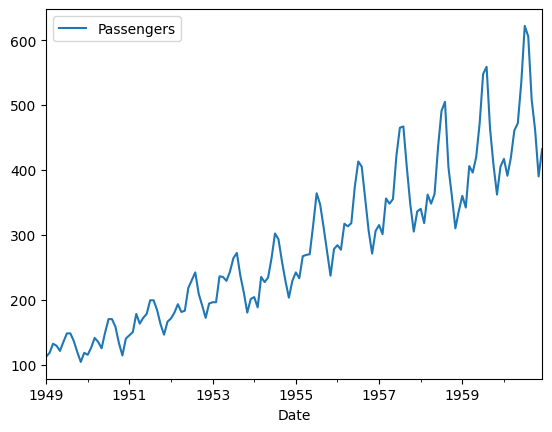

In [ ]:
df.plot()

We attempt to analyse the plot by decomposing the plot

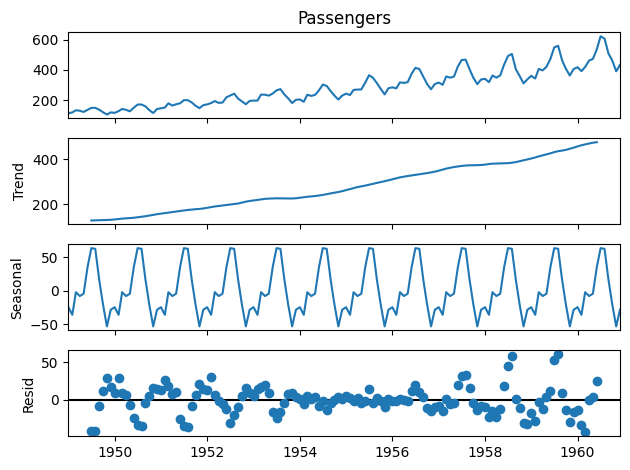

In [ ]:
result = seasonal_decompose(df['Passengers'])
result.plot();

In [ ]:
# Testing Stationarity mathematically using dickey fuller test
from statsmodels.tsa.stattools import adfuller

test_result = adfuller(df['Passengers'])

In [ ]:
#Defining a Hypothesis
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adfuller_test(df['Passengers'])

ADF Test Statistic : 0.8153688792060482
p-value : 0.991880243437641
#Lags Used : 13
Number of Observations Used : 130
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Since the data is proven not stationary, We make it stationary using differencing

In [ ]:
#Since data is seasonal difference is 12 months
df['Sales First Difference'] = df['Passengers'] - df['Passengers'].shift(12)
#df.head(28)

ADF Test Statistic : -3.383020726492481
p-value : 0.011551493085514954
#Lags Used : 1
Number of Observations Used : 130
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<Axes: xlabel='Date'>

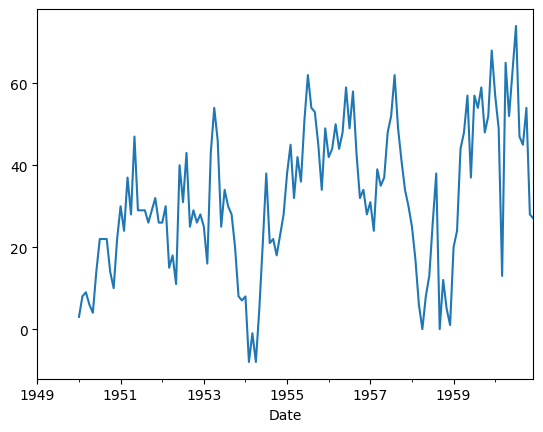

In [ ]:
#check stationarity again using dickey fuller test
adfuller_test(df['Sales First Difference'].dropna()) ## imp note use dropna
df['Sales First Difference'].plot()

# We obtained stationarity

Plotting ACF and PACF graphs

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

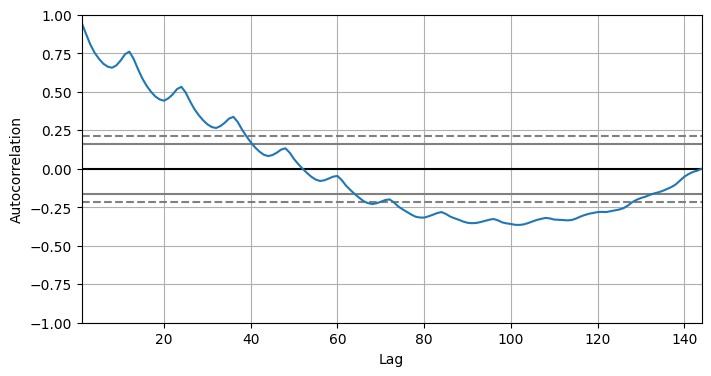

In [ ]:
plt.rcParams.update({'figure.figsize':(8,4)})
autocorrelation_plot(df['Passengers'].tolist())

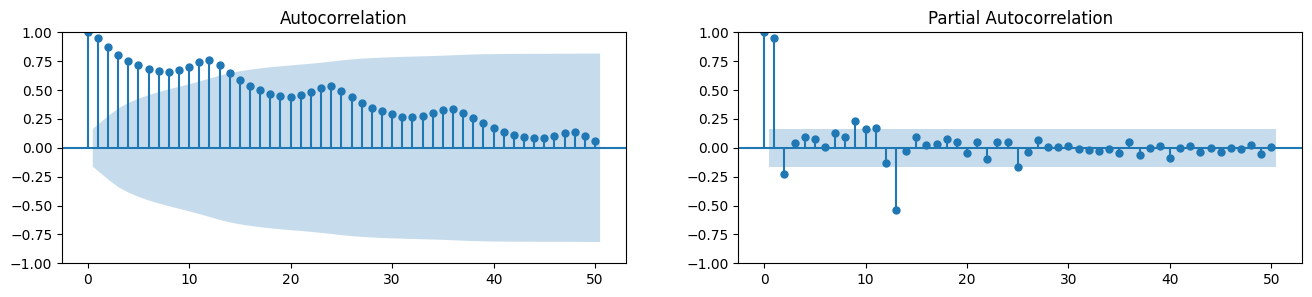

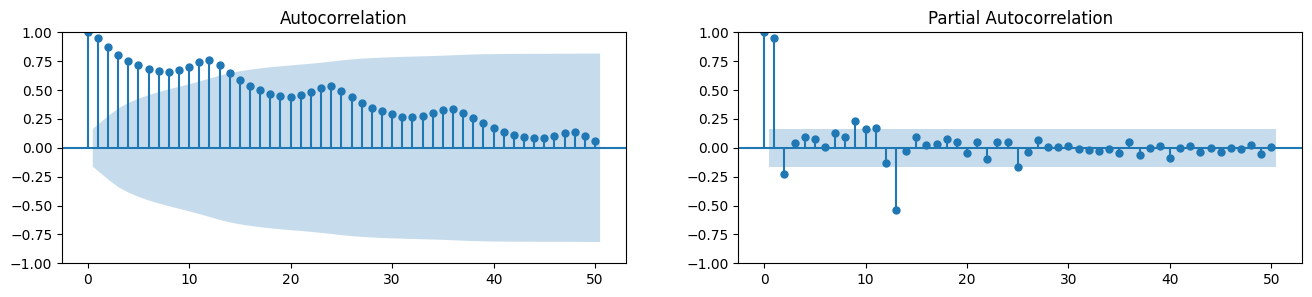

In [ ]:
# We see that at lags = 50 we see an intersection
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['Passengers'], lags=50, ax=axes[0])
plot_pacf(df['Passengers'], lags=50, ax=axes[1])

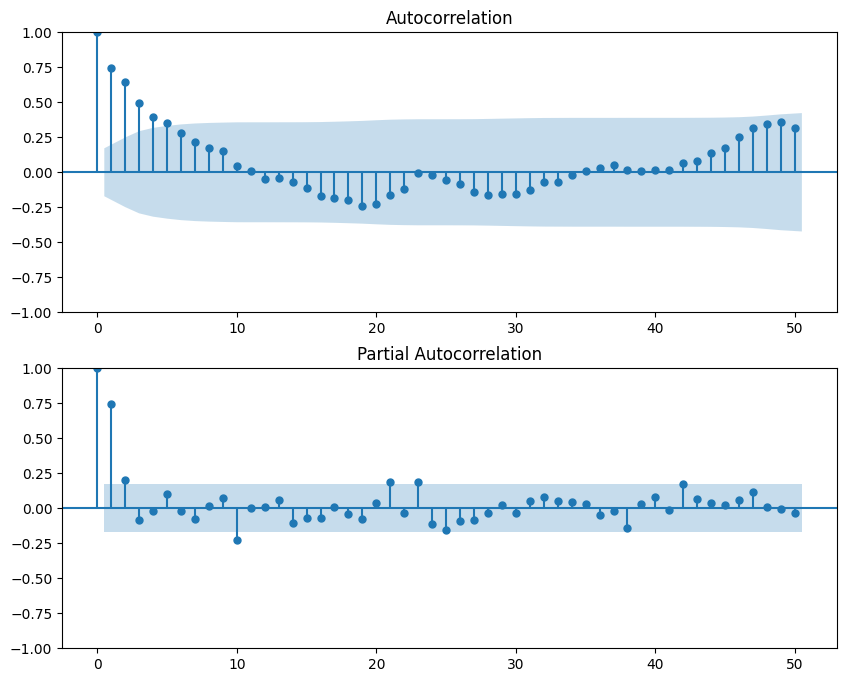

In [ ]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Sales First Difference'].iloc[13:],lags=50,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Sales First Difference'].iloc[13:],lags=50,ax=ax2)

Model Building : ARIMA Model
Parametres: ARIMA(p,d,q) : p = order of AR model, d = Order of differencing to get stationary model, q= order of MA model

for our implementation we decide on the parameters (p,d,q)=(1,1,1)

In [ ]:
#Model Building
# parameters
p,d,q = 1,1,1
model = ARIMA(df['Passengers'],order=(p,d,q))
modell = model.fit()
modell.summary()

c:\Users\Gokul\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Gokul\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Gokul\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -694.341
Date:                Thu, 04 Apr 2024   AIC                           1394.683
Time:                        15:11:56   BIC                           1403.571
Sample:                    01-01-1949   HQIC                          1398.294
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4742      0.123     -3.847      0.000      -0.716      -0.233
ma.L1          0.8635      0.078     11.051      0.000       0.710       1.017
sigma2       961.9270    107.433      8.954      0.000     751.362    1172.492
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                 2.14
Prob(Q):                              0.65   Prob(JB):                         0.34
Heteroskedasticity (H):               7.00   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

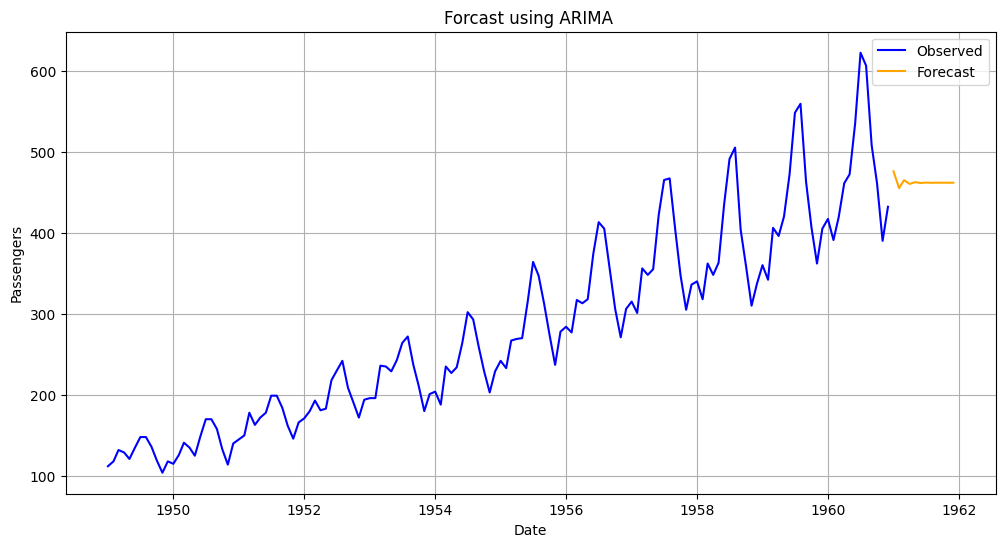

In [ ]:
# forcast using ARIMA model
forecast_steps = 12
forecast = modell.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Passengers'], label='Observed', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('No of Passengers')
plt.title('Forcast using ARIMA ')
plt.legend()
plt.grid(True)
plt.show()

Since we can see that the prediction is not that useful, We use the SARIMAX model which is helpful with seasonal data
This model has an adiitional term S for seasonality along with the default ARIMA parameters.

In [ ]:
p, d, q = 1, 1, 1
P, D, Q, S = 1, 1, 1, 12  # Seasonal order with a monthly seasonality
model = SARIMAX(df['Passengers'], order=(p, d, q), seasonal_order=(P, D, Q, S))
results = model.fit()
results.summary()


c:\Users\Gokul\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Gokul\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


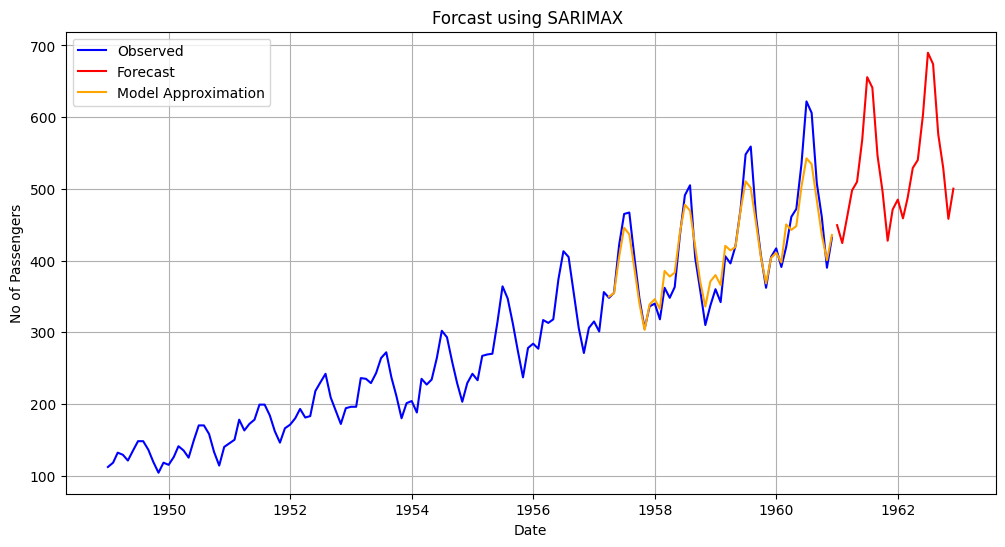

In [ ]:
df['forecast']=results.predict(start=99,end=143,dynamic=True)
forecast_steps = 24
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean

plt.figure(figsize=(12,6))
plt.plot(df.index, df['Passengers'], label='Observed', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.plot(df.index,df['forecast'],label='Model Approximation',color='orange')
plt.xlabel('Date')
plt.ylabel('No of Passengers')
plt.title('Forcast using SARIMAX ')
plt.legend()
plt.grid(True)
plt.show()

Let us verify the accuracy using some mathematical scores

In [ ]:
from sklearn.metrics import mean_squared_error,accuracy_score
from math import sqrt

rmse=sqrt(mean_squared_error(df['forecast'].dropna(),df['Passengers'].iloc[99:]))
print(f'The Root Mean Square Error for the SARIMAX model is {rmse}')

The Root Mean Square Error for the SARIMAX model is 25.669058274605202


# Now let us implement the same dataset using LSTM Model

<Axes: xlabel='Date'>

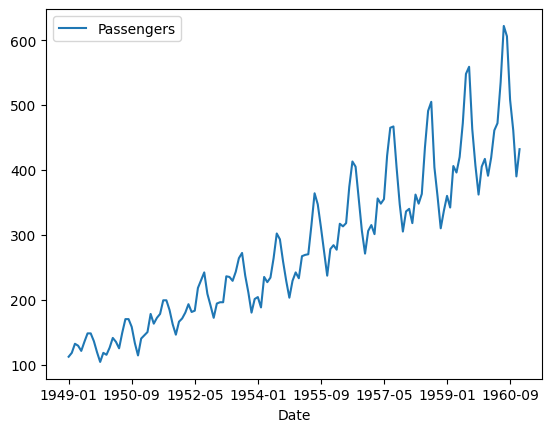

In [4]:
# load dataset
df2 = pd.read_csv('/content/AirPassengers.csv')
df2.isnull().sum() # Since we have no null values we need not do any feature engineering.
df2.columns = ['Date','Passengers'] #rename column names
df2.set_index('Date', inplace=True)
df2.plot()

We perform the seasonal decomposition as the previous model

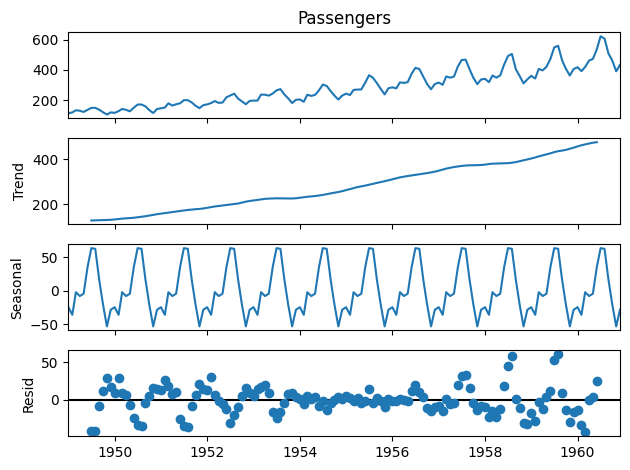

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['Passengers'])
results.plot();

We perform a simple train-test split
We can use the train-test split from sklearn but the no of samples to split is known so there is no need for it here.
We also scale the data using the MinMaxscalar function

In [5]:
# no of samples are 144, so we take 10% of the samples as testing samples.
train = df2.iloc[:130]
test = df2.iloc[130:]

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

Now that we are done with the data pre-processing, We move onto an important concept called TimeseriesGenerator which is quite useful in LSTM's.
It is used to automatically transform a univariate or multivariate time series dataset into a supervised learning problem.
Given an array [1,2,3,4,5] and we input [1,2,3] as input to the generator, it should return a output 4 and should shift and add to the input array to form [2,3,4] which outputs 5 and so on.

In [8]:
from keras.preprocessing.sequence import TimeseriesGenerator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)


**Now we define our LSTM model**

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [16]:
# define model
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                480       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
118/118 [==============================] - 2s 5ms/step - loss: 0.1409
Epoch 2/50
118/118 [==============================] - 1s 6ms/step - loss: 0.0161
Epoch 3/50
118/118 [==============================] - 1s 6ms/step - loss: 0.0108
Epoch 4/50
118/118 [==============================] - 1s 6ms/step - loss: 0.0097
Epoch 5/50
118/118 [==============================] - 1s 5ms/step - loss: 0.0094
Epoch 6/50
118/118 [==============================] - 1s 6ms/step - loss: 0.0092
Epoch 7/50
118/118 [==============================] - 1s 6ms/step - loss: 0.0091
Epoch 8/50
118/118 [==============================] - 1s 7ms/step - loss: 0.0091
Epoch 9/50
118/118 [==============================] - 1s 9ms/step - loss: 0.0090
Epoch 10/50
118/118 [==============================] - 1s 7ms/step - loss: 0.0090
Epoch 11/50
118/118 [==============================] - 1s 6ms/step - loss: 0.0086
Epoch 12/50
118/118 [==============================] - 1s 6ms/step - loss: 0.0086
Epoch 13/50
118/118 [====

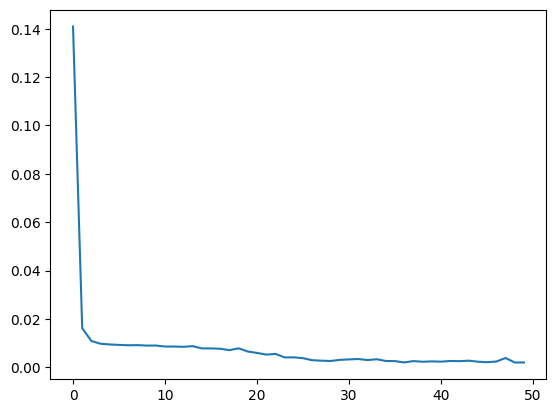

In [18]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [19]:
last_train_batch = scaled_train[-12:]
last_train_batch = last_train_batch.reshape((1, n_input, n_features))
model.predict(last_train_batch)

1/1 [==============================] - 0s 391ms/step


array([[0.6488407]], dtype=float32)

We predict the values

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):

    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]

    # append the prediction into the array
    test_predictions.append(current_pred)

    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)


test.head()

Remember we have scaled the inputs in the start so we have to scale the predictions back to the original range.

<ipython-input-25-294651e76570>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


<Axes: xlabel='Date'>

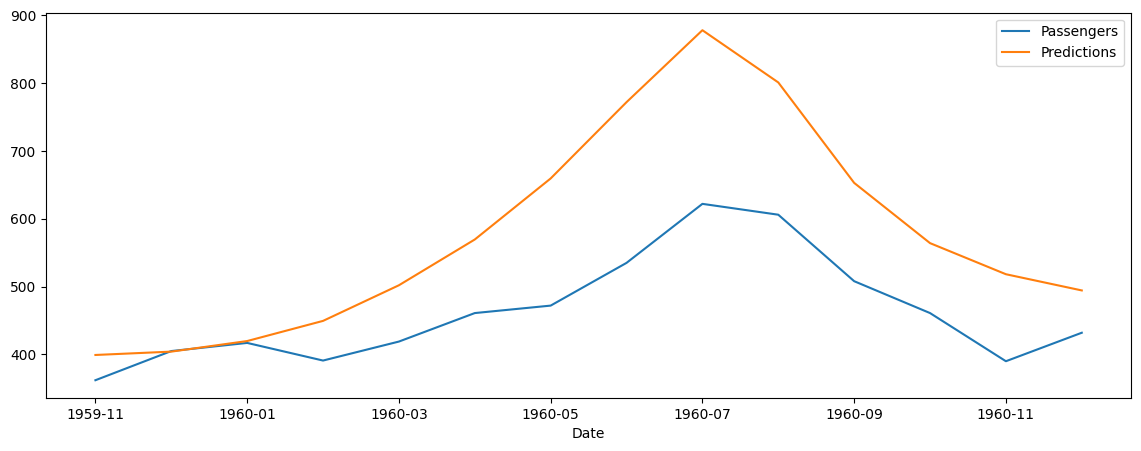

In [25]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(14,5))

We can measure the error using mathematical metrics just like we did for the previous model.

In [28]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Passengers'],test['Predictions']))
print(f'The Root Mean Square Error for the LSTM model is {rmse}')

The Root Mean Square Error for the SARIMAX model is 138.9439561456801


The LSTM model seems to have a very high error which can be reduced by altering the LSTM parameters.